# MAD! Multivariate Alteration Detection (Part 2)


In the previous part we introduced MAD. Mad can't be easily interpreted, therefore we introduce the iterative process.

In [27]:
# Enter your own export to assets path name here -----------
EXPORT_PATH = 'projects/satvis-425514/assets/imad'
# ------------------------------------------------


In [28]:
import ee

ee.Authenticate(auth_mode='notebook')
ee.Initialize(project='satvis-425514')


In [29]:
# Import other packages used in the tutorial
%matplotlib inline
import geemap
import numpy as np
import random, time
import matplotlib.pyplot as plt
from scipy.stats import norm, chi2

from pprint import pprint  # for pretty printing


### Previous Routines

In [56]:
%run mad_shared.ipynb

# Iterative Re-Weighting

$$Z = \sum_{i=1}^{n} (\frac{M_i}{\sigma_{M_i}})^2,$$

where

$$\sigma_i = var(U_i - V_i) = 2(1 - \rho_i),$$

and

$$\rho_i = cov(U_i, V_i).$$

The idea is that if we take 2 images of the same place and no actual change took place (no forest burned down and so on), the MAD variates should follow a normal distribution.

Statistics tell us that the no-change observations (no fire, no earthquake and so on) give *chi-square distributed* MAD variates with *N* degrees of freedom. If they are not chi-square distributed, something must have happened!




Sun Jun 13 10:36:49 2021
Thu Jun 16 10:46:56 2022


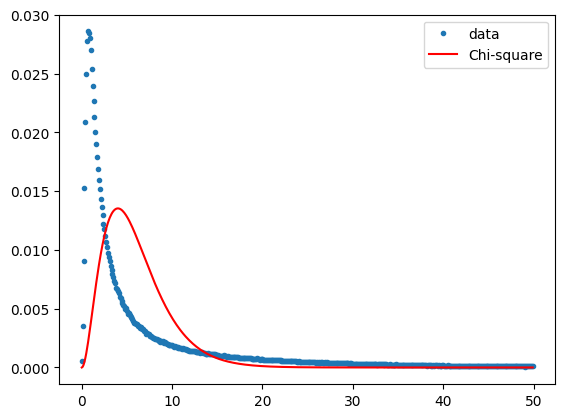

In [57]:
aoi = ee.FeatureCollection(
    'projects/google/imad_tutorial/landkreis_olpe_aoi').geometry()

visirbands = ['B2', 'B3', 'B4', 'B8', 'B11', 'B12'] 
visbands = ['B2', 'B3', 'B4']

# Collect the two Sentinel-2 images
im1, im2 = collect(aoi, '2021-06-01', '2021-06-30', '2022-06-01', '2022-06-30')

# Run MAD
U, V, MAD, Z = mad_run(im1.select(visirbands), im2.select(visirbands), scale=20)

# Plot histogram of Z
# buckets are intervals (x-axis) and we count the observations that fall into a distinct buckets (y-axis)
# we put 500 distrinct observations into 50 buckets 
# if noise would be random -> normal distribution
hist = Z.reduceRegion(ee.Reducer.fixedHistogram(0, 50, 500), aoi, scale=20).get('sum').getInfo()
a = np.array(hist)
x = a[:, 0]                     # array of bucket edge positions
y = a[:, 1]/np.sum(a[:, 1])     # normalized array of buckets contents
plt.plot(x, y, '.', label='data')
# The chi-square distribution with 6 degrees of freedom.
plt.plot(x, chi2.pdf(x, 6)/10, '-r', label='Chi-square')
plt.legend()
plt.show()

### Again Statistics :<

The $p$-value is the probability that we observe what we observe under the *null-hypothesis*.

In our case, the $p$-value is giving the probability that the pixel has that difference (color). All $p$-values should be equally likely for all pixels. If not, a change must have happened!

We can use this information iteratively to exclude pixels we do not care about from our analysis.

# Iterative MAD (IMAD)

In [ ]:
def chi2cdf(Z, df):
    '''Chi-square cumulative distribution function with df degrees of freedom.'''
    return ee.Image(Z.divide(2)).gammainc(ee.Number(df).divide(2))

def imad(current,prev):
    '''Iterator function for iMAD.'''
    done =  ee.Number(ee.Dictionary(prev).get('done'))
    return ee.Algorithms.If(done, prev, imad1(current, prev))

def imad1(current,prev):
    '''Iteratively re-weighted MAD.''' 
    # NEW! (dict magic)
    image = ee.Image(ee.Dictionary(prev).get('image'))
    Z = ee.Image(ee.Dictionary(prev).get('Z'))
    allrhos = ee.List(ee.Dictionary(prev).get('allrhos'))
    nBands = image.bandNames().length().divide(2)
    weights = chi2cdf(Z,nBands).subtract(1).multiply(-1)
    scale = ee.Dictionary(prev).getNumber('scale')
    niter = ee.Dictionary(prev).getNumber('niter')
    # Weighted stacked image and weighted covariance matrix. (as in the normal one)
    centeredImage, covarArray = covarw(image, weights, scale)
    bNames = centeredImage.bandNames()
    bNames1 = bNames.slice(0, nBands)
    bNames2 = bNames.slice(nBands)
    centeredImage1 = centeredImage.select(bNames1)
    centeredImage2 = centeredImage.select(bNames2)
    s11 = covarArray.slice(0, 0, nBands).slice(1, 0, nBands)
    s22 = covarArray.slice(0, nBands).slice(1, nBands)
    s12 = covarArray.slice(0, 0, nBands).slice(1, nBands)
    s21 = covarArray.slice(0, nBands).slice(1, 0, nBands)
    c1 = s12.matrixMultiply(s22.matrixInverse()).matrixMultiply(s21)
    b1 = s11
    c2 = s21.matrixMultiply(s11.matrixInverse()).matrixMultiply(s12)
    b2 = s22
    # Solution of generalized eigenproblems (as before).
    lambdas, A = geneiv(c1, b1)
    _, B       = geneiv(c2, b2)
    rhos = lambdas.sqrt().project(ee.List([1]))
    # NEW! (Test for convergence by seeing no more differences in the canonical correlation coeffs).
    lastrhos = ee.Array(allrhos.get(-1))
    done = rhos.subtract(lastrhos) \
               .abs() \
               .reduce(ee.Reducer.max(), ee.List([0])) \
               .lt(ee.Number(0.0001)) \
               .toList() \
               .get(0)
    allrhos = allrhos.cat([rhos.toList()])
    # MAD variances.
    sigma2s = rhos.subtract(1).multiply(-2).toList()
    sigma2s = ee.Image.constant(sigma2s)
    # Ensure sum of positive correlations between X and U is positive.
    tmp = s11.matrixDiagonal().sqrt()
    ones = tmp.multiply(0).add(1)
    tmp = ones.divide(tmp).matrixToDiag()
    s = tmp.matrixMultiply(s11).matrixMultiply(A).reduce(ee.Reducer.sum(), [0]).transpose()
    A = A.matrixMultiply(s.divide(s.abs()).matrixToDiag())
    # Ensure positive correlation.
    tmp = A.transpose().matrixMultiply(s12).matrixMultiply(B).matrixDiagonal()
    tmp = tmp.divide(tmp.abs()).matrixToDiag()
    B = B.matrixMultiply(tmp)
    # Canonical and MAD variates.
    centeredImage1Array = centeredImage1.toArray().toArray(1)
    centeredImage2Array = centeredImage2.toArray().toArray(1)
    U = ee.Image(A.transpose()).matrixMultiply(centeredImage1Array) \
                   .arrayProject([0]) \
                   .arrayFlatten([bNames1])
    V = ee.Image(B.transpose()).matrixMultiply(centeredImage2Array) \
                   .arrayProject([0]) \
                   .arrayFlatten([bNames2])
    iMAD = U.subtract(V)
    # Chi-square image.
    Z = iMAD.pow(2) \
              .divide(sigma2s) \
              .reduce(ee.Reducer.sum())
    return ee.Dictionary({'done': done, 'scale': scale, 'niter': niter.add(1),
                          'image': image, 'allrhos': allrhos, 'Z': Z, 'iMAD': iMAD})



In [ ]:
def run_imad(aoi, image1, image2, assetId, scale=20, maxiter=100):
    try:
        N = image1.bandNames().length().getInfo()
        imadnames = ['iMAD'+str(i+1) for i in range(N)]
        imadnames.append('Z')
        # Maximum iterations.
        inputlist = ee.List.sequence(1, maxiter)
        first = ee.Dictionary({'done':0,
                            'scale': scale,
                            'niter': ee.Number(0),
                            'image': image1.addBands(image2),
                            'allrhos': [ee.List.sequence(1, N)],
                            'Z': ee.Image.constant(0),
                            'iMAD': ee.Image.constant(0)})
        # Iteration.
        result = ee.Dictionary(inputlist.iterate(imad, first))
        # Retrieve results.
        iMAD = ee.Image(result.get('iMAD')).clip(aoi)
        rhos = ee.String.encodeJSON(ee.List(result.get('allrhos')).get(-1))
        Z = ee.Image(result.get('Z'))
        niter = result.getNumber('niter')
        # Export iMAD and Z as a singe image, including rhos and number of iterations in properties.
        iMAD_export = ee.Image.cat(iMAD, Z).rename(imadnames).set('rhos', rhos, 'niter', niter)
        assexport = ee.batch.Export.image.toAsset(iMAD_export,
                        description='assetExportTask',
                        assetId=assetId, scale=scale, maxPixels=1e10)
        assexport.start()
        print('Exporting iMAD to %s\n task id: %s'%(assetId, str(assexport.id)))
    except Exception as e:
        print('Error: %s'%e)


In [ ]:
asset_path = f'{EXPORT_PATH}LandkreisOlpe'
run_imad(aoi, im1.select(visirbands), im2.select(visirbands), asset_path)



Exporting iMAD to projects/satvis-425514/assets/imadLandkreisOlpe
 task id: RBAPCW7ICHNLNTM4O3ZWQJV6


In [ ]:
tasks = ee.data.getTaskList()
tasks


[{'state': 'RUNNING',
  'description': 'assetExportTask',
  'priority': 100,
  'creation_timestamp_ms': 1720176881836,
  'update_timestamp_ms': 1720177992842,
  'start_timestamp_ms': 1720176891299,
  'task_type': 'EXPORT_IMAGE',
  'attempt': 1,
  'id': 'RBAPCW7ICHNLNTM4O3ZWQJV6',
  'name': 'projects/satvis-425514/operations/RBAPCW7ICHNLNTM4O3ZWQJV6'}]

In [ ]:
im_imad = ee.Image(
    f'{EXPORT_PATH}LandkreisOlpe7Bands').select(0, 1, 2, 3, 4, 5)
im_z = ee.Image(
    f'{EXPORT_PATH}LandkreisOlpe7Bands').select(6).rename('Z')
niter = im_imad.get('niter').getInfo()
rhos = ee.List(im_imad.get('rhos')).getInfo()
print('iteratons: %i'%niter)
print('canonical correlations: %s'%rhos)


iteratons: 29
canonical correlations: [0.9981412348663193,0.9819236987012055,0.959651417972682,0.882085132419077,0.8474075273608223,0.688117750289947]


Now the canonical correlations are much closer one to another. Also, they are very close to 1. This means they are very similar. Let's see how the chi-sqaure test, checking if the pixels did actual change performs now.

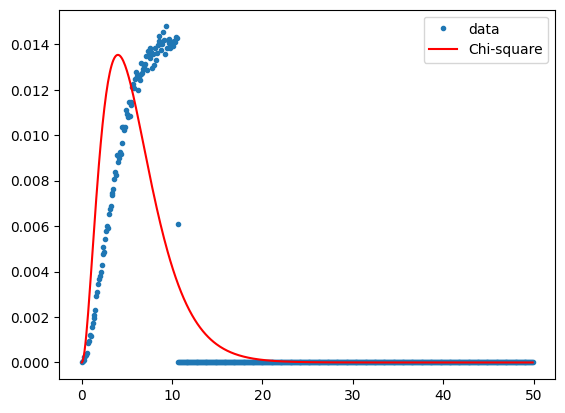

In [32]:
scale = 20
# p-values image
pval = chi2cdf(im_z, 6).subtract(1).multiply(-1).rename('pval') # 1 - CDF(x)
# No-change mask (use p-values greater than 0.1)
# any pixel with probability greater than 0.1 we assume to be no change
noChangeMask = pval.gt(0.1) 

hist = im_z.updateMask(noChangeMask).reduceRegion(ee.Reducer \
           .fixedHistogram(0, 50, 500), aoi, scale=scale, maxPixels=1e11).get('Z') \
           .getInfo()
a = np.array(hist)
x = a[:, 0]                     # array of bucket edge positions
y = a[:, 1]/np.sum(a[:, 1])     # normalized array of buckets contents
plt.plot(x, y, '.', label='data')
# The chi-square distribution with 6 degrees of freedom.
plt.plot(x, chi2.pdf(x, 6)/10, '-r', label='Chi-square')
plt.legend()
plt.show()

In [1]:
M1 = geemap.Map()
M1.centerObject(aoi, 11)
# display_ls(im1.select(visbands), M2, 'Image 1')
# display_ls(im2.select(visbands), M2, 'Image 2')
# display_ls(diff, M2, 'Difference')
display_ls(im_imad.select('iMAD1', 'iMAD2', 'iMAD3'), M1, 'iMAD123', True)

M1

NameError: name 'geemap' is not defined

#### Aside

*Top of Atmosphere* (TOA) images are more noisy, while *surface* images should not have changes.

**Def Harmonizing:** Making different datasets compatible and comparable

**NDVI:** Normalized Difference Vegetation Index

# Clustering

We are performing an *unsupervised classification*.

**Algorithms:** K-means clusterer, Euclidean distance measure

We first standardize by dividing by the variance of the no-change pixels. This makes the No-Change Cluster more compact => the distance between the no-change pixels is smaller.

**Variance:**
$$\sigma_i = \sqrt{2(1 - \rho_i)}$$

In [11]:
# Standardize to no change sigmas.
sigma2s = ee.Image.constant([2*(1-x) for x in eval(rhos)])
im_imadstd = im_imad.divide(sigma2s.sqrt())
# Collect training data.
training = im_imadstd.sample(region=aoi, scale=scale, numPixels=50000)
# Train the clusterer.
clusterer = ee.Clusterer.wekaKMeans(4).train(training) # WEKA K MEANS CLUSTERER
# Classify the standardized imad image.
result = im_imadstd.cluster(clusterer)

In [59]:
M2 = geemap.Map()
M2.centerObject(aoi, 13)
display_ls(im1.select(visbands), M2, 'im1')
display_ls(im2.select(visbands), M2, 'im2')
cluster0 = result.updateMask(result.eq(0))
cluster1 = result.updateMask(result.eq(1))
cluster2 = result.updateMask(result.eq(2))
cluster3 = result.updateMask(result.eq(3))
palette = ['red', 'yellow', 'blue', 'black']
vis_params = {'min': 0, 'max': 3, 'palette': palette}

M2.addLayer(cluster0, vis_params, 'new clearcuts')
M2.addLayer(cluster1, vis_params, 'agricultre')
M2.addLayer(cluster2, vis_params, 'prior clearcuts')
M2.addLayer(cluster3, vis_params, 'no change')

M2

Map(center=[51.08617675675536, 7.976478425048881], controls=(WidgetControl(options=['position', 'transparent_b…

# Comparison with Dynamic Word

Dynamic World is a dataset that contain near-time land use land cover predictions.

In [38]:
dyn = ee.ImageCollection('GOOGLE/DYNAMICWORLD/V1') \
                    .filterDate('2021-06-01', '2022-06-30') \
                    .filterBounds(aoi) \
                    .select('label').mosaic()
# 'trees' class = class 1
dw = dyn.clip(aoi).updateMask(dyn.eq(1))

M3 = geemap.Map()
M3.centerObject(aoi, 13)
display_ls(im1.select(visbands), M3, 'im1')
display_ls(im2.select(visbands), M3, 'im2')
M3.addLayer(dw, {'min': 0, 'max': 1, 'palette': ['black','green']}, 'dynamic word')
M3.addLayer(cluster0, vis_params, 'new clearcuts')

M3 

Map(center=[51.08617675675536, 7.976478425048881], controls=(WidgetControl(options=['position', 'transparent_b…

## Simple Difference Revisited

Good discrimination of the *clearcuts* -> Near infrared (NIR) abnd is sensitive to vegetation changes. 

Many false positives -> in the agriculture fields and for the big ass reservoir on the left.

Above statements are true for the simple difference.

*Conclusion:* Simple difference not as good.

In [40]:
M4 = geemap.Map()
M4.centerObject(aoi, 13)
diff = im1.subtract(im2).select(visirbands)
training = diff.sample(region=aoi, scale=20, numPixels=50000)
clusterer = ee.Clusterer.wekaKMeans(4).train(training)
result1 = diff.cluster(clusterer)
cluster0d = result1.updateMask(result1.eq(0))

display_ls(im1.select(visbands), M4, 'im1')
display_ls(im2.select(visbands), M4, 'im2')
M4.addLayer(cluster0d, {'min': 0, 'max': 3, 'palette': ['orange', 'yellow', 'blue', 'black']}, 'clearcuts (diff)')
M4.addLayer(cluster0, vis_params, 'clearcuts (iMAD)')

M4 

Map(center=[51.08617675675536, 7.976478425048881], controls=(WidgetControl(options=['position', 'transparent_b…

# Deforestation Quantified

We find that this amount of forest was lost (9.3% woodland at that time).

In [41]:
# Minimum contiguous area requirement (0.2 hectare).
contArea = cluster0.connectedPixelCount().selfMask()
# 0.2 hectare = 5 pixels @ 400 sq. meters.
mp = contArea.gte(ee.Number(5)).selfMask()
# Clear cuts in hectares.
pixelArea = mp.multiply(ee.Image.pixelArea()).divide(10000)
clearcutArea = pixelArea.reduceRegion(
                    reducer=ee.Reducer.sum(),
                    geometry=aoi,
                    scale=scale,
                    maxPixels=1e11)
ccA = clearcutArea.get('cluster').getInfo()
print(ccA, 'hectare')


3720.3840217133484 hectare


The simple difference overestimates by 1/3.

In [42]:
contArea = cluster0d.connectedPixelCount().selfMask()
mp = contArea.gte(ee.Number(5)).selfMask()
pixelArea = mp.multiply(ee.Image.pixelArea()).divide(10000)
clearcutArea = pixelArea.reduceRegion(
                    reducer=ee.Reducer.sum(),
                    geometry=aoi,
                    scale=scale,
                    maxPixels=1e11)
ccA = clearcutArea.get('cluster').getInfo()
print(ccA, 'hectare')


4875.7986791732765 hectare


# Exercises

## Different Clustering (EX1)

Comparison with KMeans:

**LVQ:** Fails
**CascadeKMeans:** Works the same but switches the *prior clearcuts* with *new clearcuts*
**Cobweb:** Crashed the application
**XMeans:** 


In [112]:
# Cluster
training_ex1 = im_imadstd.sample(region=aoi, scale=scale, numPixels=50000)
clusterer_ex1 = ee.Clusterer.wekaXMeans().train(training_ex1)
result_ex1 = im_imadstd.cluster(clusterer_ex1)

In [113]:
EM1 = geemap.Map()
EM1.centerObject(aoi, 13)
display_ls(im2.select(visbands), EM1, 'im2')
cluster0_ex1 = result_ex1.updateMask(result_ex1.eq(0))
cluster1_ex1 = result_ex1.updateMask(result_ex1.eq(1))
cluster2_ex1 = result_ex1.updateMask(result_ex1.eq(2))
cluster3_ex1 = result_ex1.updateMask(result_ex1.eq(3))
palette = ['red', 'yellow', 'blue', 'black']
vis_params = {'min': 0, 'max': 3, 'palette': palette}

EM1.addLayer(cluster0_ex1, vis_params, 'new clearcuts')
EM1.addLayer(cluster1_ex1, vis_params, 'agricultre')
EM1.addLayer(cluster2_ex1, vis_params, 'prior clearcuts')
EM1.addLayer(cluster3_ex1, vis_params, 'no change')

EM1


## More Bands (EX 2)

In [13]:
# visirbands + rededgebands
rededgebands = ['B5', 'B6', 'B7', 'B8A']

asset_path = f'{EXPORT_PATH}LandkreisOlpeRedEdged'
run_imad(aoi, im1.select(visirbands + rededgebands), im2.select(visirbands + rededgebands), asset_path)

Exporting iMAD to projects/satvis-425514/assets/imadLandkreisOlpeRedEdged
 task id: QM7EPKVMPBQKTGF4ZCTNO56D


In [21]:
tasks = ee.data.getTaskList()
tasks

[{'state': 'COMPLETED',
  'description': 'assetExportTask',
  'priority': 100,
  'creation_timestamp_ms': 1720193092618,
  'update_timestamp_ms': 1720195239607,
  'start_timestamp_ms': 1720193099110,
  'task_type': 'EXPORT_IMAGE',
  'destination_uris': ['https://code.earthengine.google.com/?asset=projects/satvis-425514/assets/imadLandkreisOlpeRedEdged'],
  'attempt': 1,
  'batch_eecu_usage_seconds': 13916.8935546875,
  'id': 'QM7EPKVMPBQKTGF4ZCTNO56D',
  'name': 'projects/satvis-425514/operations/QM7EPKVMPBQKTGF4ZCTNO56D'},
 {'state': 'COMPLETED',
  'description': 'assetExportTask',
  'priority': 100,
  'creation_timestamp_ms': 1720176881836,
  'update_timestamp_ms': 1720178201769,
  'start_timestamp_ms': 1720176891299,
  'task_type': 'EXPORT_IMAGE',
  'destination_uris': ['https://code.earthengine.google.com/?asset=projects/satvis-425514/assets/imadLandkreisOlpe'],
  'attempt': 1,
  'batch_eecu_usage_seconds': 6183.25927734375,
  'id': 'RBAPCW7ICHNLNTM4O3ZWQJV6',
  'name': 'projects/s

In [35]:
im_imad_red = ee.Image(
    f'{EXPORT_PATH}LandkreisOlpeRedEdged').select(0, 1, 2, 3, 4, 5, 6, 7, 8, 9)
im_z_red = ee.Image(
    f'{EXPORT_PATH}LandkreisOlpeRedEdged').select(10).rename('Z')
niter = im_imad_red.get('niter').getInfo()
rhos_red = ee.List(im_imad_red.get('rhos')).getInfo()
print('iteratons: %i'%niter)
print('canonical correlations: %s'%rhos_red)

iteratons: 45
canonical correlations: [0.9962110555290892,0.9750186626355055,0.9485900751736506,0.8418165452013016,0.7663769668282001,0.7235353353860124,0.4684269614344624,0.46110100170559193,0.41329433667624915,0.4012592699670804]


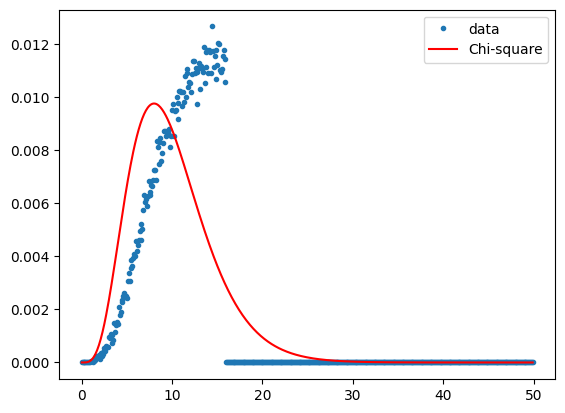

In [36]:
scale = 20
# p-values image
pval = chi2cdf(im_z_red, 10).subtract(1).multiply(-1).rename('pval') # 1 - CDF(x)
noChangeMask = pval.gt(0.1) 

hist = im_z_red.updateMask(noChangeMask).reduceRegion(ee.Reducer \
           .fixedHistogram(0, 50, 500), aoi, scale=scale, maxPixels=1e11).get('Z') \
           .getInfo()
a = np.array(hist)
x = a[:, 0]                     # array of bucket edge positions
y = a[:, 1]/np.sum(a[:, 1])     # normalized array of buckets contents
plt.plot(x, y, '.', label='data')
# The chi-square distribution with 6 degrees of freedom.
plt.plot(x, chi2.pdf(x, 10)/10, '-r', label='Chi-square')
plt.legend()
plt.show()

In [64]:
sigma2s_red = ee.Image.constant([2*(1-x) for x in eval(rhos_red)])
im_imadstd_red = im_imad_red.divide(sigma2s_red.sqrt())
training_red = im_imadstd_red.sample(region=aoi, scale=scale, numPixels=50000)
clusterer_red = ee.Clusterer.wekaKMeans(5).train(training_red)
result_red = im_imadstd_red.cluster(clusterer_red)

In [69]:
EM2 = geemap.Map()
EM2.centerObject(aoi, 13)
display_ls(im1.select(visbands), EM2, 'im1')
display_ls(im2.select(visbands), EM2, 'im2')
cluster0_red = result_red.updateMask(result_red.eq(0))
cluster1_red = result_red.updateMask(result_red.eq(1))
cluster2_red = result_red.updateMask(result_red.eq(2))
cluster3_red = result_red.updateMask(result_red.eq(3))
cluster4_red = result_red.updateMask(result_red.eq(4))
palette = ['blue', 'yellow', 'orange', 'black', 'red']
vis_params = {'min': 0, 'max': 4, 'palette': palette}

EM2.addLayer(cluster0_red, vis_params, 'crops 1')
EM2.addLayer(cluster1_red, vis_params, 'city & crops 2')
EM2.addLayer(cluster2_red, vis_params, 'city & crops 3')
EM2.addLayer(cluster3_red, vis_params, 'no change')
EM2.addLayer(cluster4_red, vis_params, 'new clearcuts')
EM2

Map(center=[51.08617675675536, 7.976478425048881], controls=(WidgetControl(options=['position', 'transparent_b…

In [70]:
# Minimum contiguous area requirement (0.2 hectare).
contArea = cluster4_red.connectedPixelCount().selfMask()
# 0.2 hectare = 5 pixels @ 400 sq. meters.
mp = contArea.gte(ee.Number(5)).selfMask()
# Clear cuts in hectares.
pixelArea = mp.multiply(ee.Image.pixelArea()).divide(10000)
clearcutArea = pixelArea.reduceRegion(
                    reducer=ee.Reducer.sum(),
                    geometry=aoi,
                    scale=scale,
                    maxPixels=1e11)
ccA = clearcutArea.get('cluster').getInfo()
print(ccA, 'hectare')

4645.719924298837 hectare


### Findings:

1) Red edge bands are good for crops (particularly sensitive to variations in chlorophyll content)
2) Not particularly amazing for deforestation but it works (I think with less precision?)
3) Material degradation can induce changes in near infrared? Cities and roads emit changes which is interesting
4) We want more clusters

## Urban (EX3)

In [16]:
# TIGER------: US Census Counties from the GEE Data Archive.
counties = ee.FeatureCollection('TIGER/2016/Counties')
filtered = counties.filter(ee.Filter.eq('NAMELSAD', 'Montgomery County'))
aois = filtered.geometry()
# There are many Montgomery Counties in USA, we want the 12th in the list.
aoi = ee.Geometry(aois.geometries().get(12))
im1, im2 = collect(aoi, '2021-07-01', '2021-07-30', '2022-06-01', '2022-06-30')
M5 = geemap.Map()
M5.centerObject(aoi, 10)
display_ls(im1.select(visbands), M5, 'Image 1')
display_ls(im2.select(visbands), M5, 'Image 2')

M5

Sun Jul 25 17:15:25 2021
Sat Jun 25 17:15:27 2022


Map(center=[30.30018238996553, -95.50281925712775], controls=(WidgetControl(options=['position', 'transparent_…